<a href="https://colab.research.google.com/github/jplazcano87/ActionButton/blob/master/Copy_of_Trabajo_final_20241015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
Segundo Semestre 2024<br>


<h1><center> Fundamentos de Machine Learning e Inteligencia Artificial Generativa:

Trabajo final </center></h1>
        **Profesor**: Miguel Fernández<br>
Fecha de entrega: 27/10/2024 23:59

---

# Integrantes
* Estudiante 1:
* Estudiante 2:

#Introducción

Este trabajo considera 2 secciones:
* Parte 1: Entrenar clasificadores para detectar lenguaje de odio en mensajes de redes sociales.

* Parte 2: Comparar los modelos T5-small vs GPT vs Llama en la tarea Question answering (QA).

# Librerías

In [1]:
!pip install transformers==4.45.2


# Parte 1: Clasificación de texto (30 puntos)

El conjunto de datos utilizado en este estudio se construyó a partir de tweets obtenidos a través de la API de Twitter y filtrados utilizando un léxico de discurso de odio proporcionado por Hatebase.org. Inicialmente, se identificaron y recopilaron tweets que contenían términos específicos catalogados como discurso de odio por la comunidad. Este proceso resultó en una muestra de 85.4 millones de tweets, provenientes de 33,458 usuarios de Twitter.

Posteriormente, se realizó una selección aleatoria de tweets de esta muestra inicial para su análisis detallado. Estos tweets fueron evaluados manualmente por trabajadores de CrowdFlower (CF), quienes clasificaron cada tweet en una de tres categorías: discurso de odio, lenguaje ofensivo pero no discurso de odio, y ni ofensivo ni discurso de odio.

**Estructura del dataset**

Para el desarrollo de la tarea, se deben concentrar en dos columnas:

* tweet: Contiene la sentencia que debe ser evaluada.
* label: Clasificación asociada a cada sentencia de la variable tweet.

Respecto a la variable label, se tiene la siguiente codificación:

* 0 - discurso de odio
* 1 - lenguaje ofensivo
* 2 - ninguno

El conjunto de datos ya está divido en train (df_train) y test (df_test)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import RobertaModel, RobertaTokenizer, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
import json
from tqdm import tqdm


import logging
logging.basicConfig(level=logging.ERROR)

In [3]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 Descripción del conjunto de datos (6 puntos)

Concatene ambos conjuntos de datos para tener una mirada general del dataset. Responda las siguiente preguntas:

* Grafique el número de ejemplos por tipo de clase. ¿El dataset está balanceado?
* Calcule el largo de las oraciones para cada clase, considerando el número de palabras. ¿Se observa algún patrón?
* Para cada clase, presente las 40 palabras más frecuentes. Comente.

Respuesta:

In [ ]:

dataframe_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TrabajoFinal/df_train.csv")
dataframe_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TrabajoFinal/df_test.csv")

dataset = pd.concat([dataframe_train, dataframe_test], axis=0)
dataset.head(20)


,Unnamed: 0,count,hate_speech,offensive_language,neither,label,tweet
0,21744,3,0,3,0,1,Talking Angela is a hoe
1,12933,3,0,2,1,1,Lol they tricking niccas left n right
2,997,3,0,3,0,1,&#128514;&#128514; bitches get stuff done. htt...
3,2534,3,0,3,0,1,@ArtaleGaspare bitch i got the flameeee
4,7470,3,0,3,0,1,@vivaalakatyy @brotherbill7 @JHuff_5 good bitc...
5,10955,6,0,6,0,1,I like saying the word pussy hoe ion no why!!!
6,22423,3,1,2,0,1,This bitch forehead. Hairline. Who lied to her...
7,6882,3,0,3,0,1,@mingtong007 you still are a cunt
8,10557,3,0,3,0,1,I feel bad for her nicca tho ... Ya girl a hoe...
9,12882,3,0,1,2,2,Log off nigger RT @PoloKingBC: #relationshipgo...


<Axes: xlabel='label'>

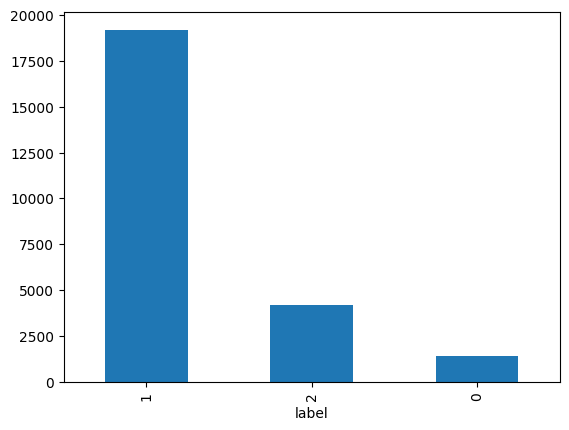

In [ ]:
dataset['label'].value_counts().plot(kind='bar')
# En el Gráfico se observa que hay muchos más tweets en la categoría 1 que corresponde a lenguaje ofensivo, por lo cual el dataset
# no está balanceado


In [ ]:
dataset_category_1 = dataset[dataset['label'] == 1]
dataset_category_2 = dataset[dataset['label'] == 2]
dataset_category_0 = dataset[dataset['label'] == 0]



In [ ]:
dataset_category_1.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,label,tweet
0,21744,3,0,3,0,1,Talking Angela is a hoe
1,12933,3,0,2,1,1,Lol they tricking niccas left n right
2,997,3,0,3,0,1,&#128514;&#128514; bitches get stuff done. htt...
3,2534,3,0,3,0,1,@ArtaleGaspare bitch i got the flameeee
4,7470,3,0,3,0,1,@vivaalakatyy @brotherbill7 @JHuff_5 good bitc...
5,10955,6,0,6,0,1,I like saying the word pussy hoe ion no why!!!
6,22423,3,1,2,0,1,This bitch forehead. Hairline. Who lied to her...
7,6882,3,0,3,0,1,@mingtong007 you still are a cunt
8,10557,3,0,3,0,1,I feel bad for her nicca tho ... Ya girl a hoe...
10,4309,3,0,2,1,1,@MrNwachukwu naw them boys trash we started co...


In [ ]:
corpus_cat_1 = " ".join(title for title in dataset_category_1["tweet"])
len_1 = len(corpus_cat_1)

In [ ]:
corpus_cat_0 = " ".join(title for title in dataset_category_0["tweet"])
len_0 = len(corpus_cat_0)

In [ ]:
corpus_cat_2 = " ".join(title for title in dataset_category_2["tweet"])
len_2 = len(corpus_cat_2)

In [ ]:
print(f"corpus 0: {len_0}")
print(f"corpus 1: {len_1}")
print(f"corpus 2: {len_2}")

largest = max(len_0,len_1, len_2)
print(f"The largest number is: {largest}")
## la categoría con más palabras es 1 que corresponde a lenguaje ofensivo, lo que se condice con ser la categoría con mayor cantidad
## de ocurrencias en el dataset

corpus 0: 122388
corpus 1: 1620731
corpus 2: 399023
The largest number is: 1620731


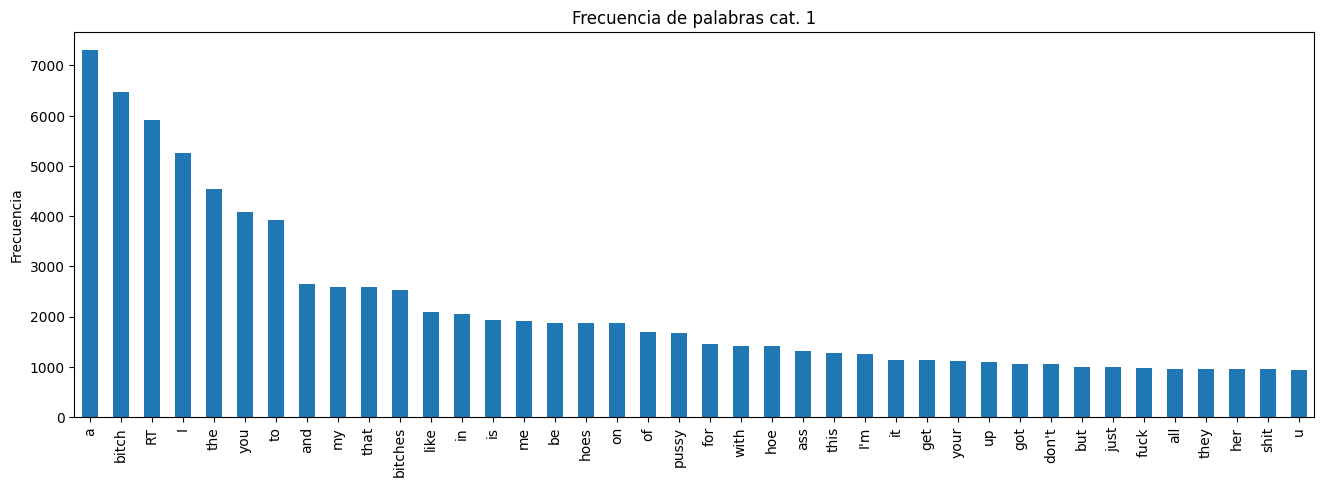

In [ ]:


pd.Series(corpus_cat_1.split()).value_counts()
pd.DataFrame(pd.Series(corpus_cat_1.split()).value_counts())[:40].plot.bar(figsize=(16, 5),color="tab:blue")
plt.xticks(rotation=90)
plt.title("Frecuencia de palabras cat. 1")
plt.ylabel("Frecuencia")
plt.legend('', frameon=False)


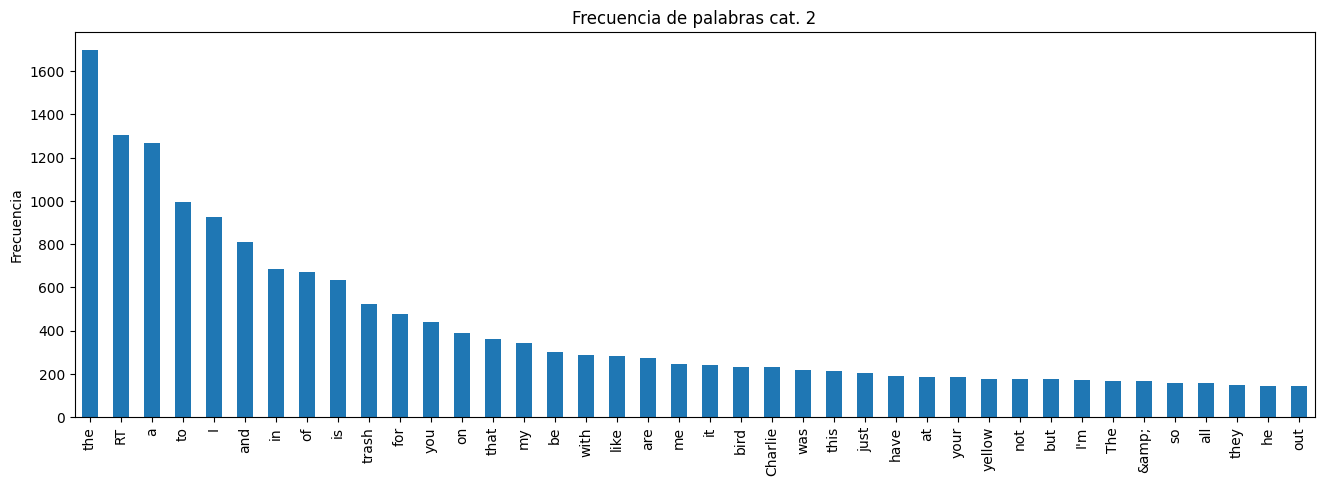

In [ ]:

pd.Series(corpus_cat_2.split()).value_counts()


pd.DataFrame(pd.Series(corpus_cat_2.split()).value_counts())[:40].plot.bar(figsize=(16, 5),color="tab:blue")
plt.xticks(rotation=90)
plt.title("Frecuencia de palabras cat. 2")
plt.ylabel("Frecuencia")
plt.legend('', frameon=False)

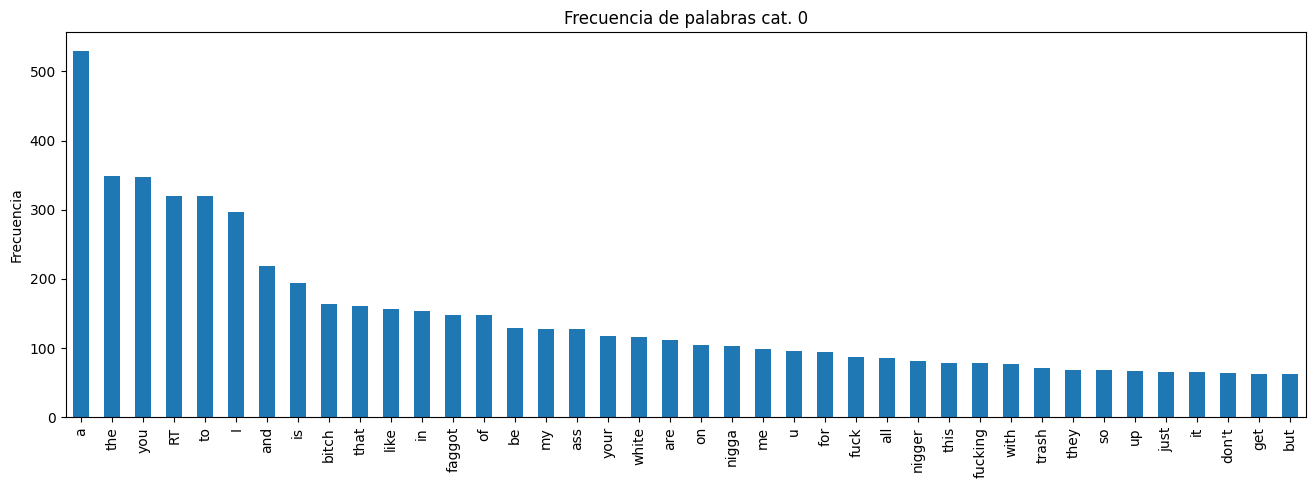

In [ ]:

corpus_cat_0
pd.Series(corpus_cat_0.split()).value_counts()


pd.DataFrame(pd.Series(corpus_cat_0.split()).value_counts())[:40].plot.bar(figsize=(16, 5),color="tab:blue")
plt.xticks(rotation=90)
plt.title("Frecuencia de palabras cat. 0")
plt.ylabel("Frecuencia")
plt.legend('', frameon=False)

Realice un preprocesamiento del texto. Justifique sus decisiones.

De implementar esta solución, siga trabajando con los conjuntos procesados para crear clasificadores basados en BOW y TF-IDF.

Respecto al entrenamiento del modelo transformer, evalúe si es conveniente aplicar el mismo preprocesamiento.

## BONUS: Preprocesamiento de texto (+4 puntos)

In [ ]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 71.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Respuesta:

In [ ]:
import string
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm") # instanciar el modelo en inglés de spacy
REGX_USERNAME = r"@[A-Za-z0-9$-_@.&+]+"

def preprocessing(text):
  text = text.lower()
  text = re.sub(REGX_USERNAME, ' ', text)
  tokens = [token.text for token in nlp(text)]
  tokens = [t for t in tokens if t not in STOP_WORDS and t not in string.punctuation and len(t) > 2]
  tokens = [t for t in tokens if not t.isdigit()]

  return " ".join(tokens)

In [ ]:
clean_values = dataset["tweet"].apply(preprocessing)

KeyboardInterrupt: 

In [ ]:
clean_values.head(10)

## 1.2 Entrenar clasificador con BOW (7 puntos)

Construya la matriz Bag of Words (BOW) para los conjuntos train y test. Indique el tamaño del vocabulario considerando el set de train. Luego, entrene un clasificador utilizando una técnica de machine learning.

Calcule las métricas Precision, Recall y F1-score para el conjunto test (general y por clase). Comente los resultados.

Respuesta:

In [ ]:
from sklearn.model_selection import train_test_split

X_train = dataframe_train["tweet"]
y_train = dataframe_train["label"]



X_test = dataframe_test["tweet"]
y_test = dataframe_test["label"]


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (19826,)
y_train shape: (19826,)
X_test shape: (4957,)
y_test shape: (4957,)


In [ ]:
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
#Se aplica fit_transforms sobre X_train_bow.
bow_X_train = count_vectorizer.fit_transform(X_train)

#Al trabajar con X_test_bow, solo se aplica transform! Recuerden que el set de test representa un conjunto de datos no visto y
#podría ocurrir que en test existan palabras nuevas no vistas en train.
bow_X_test = count_vectorizer.transform(X_test)

In [ ]:
count_vectorizer = CountVectorizer()
bow_X  = count_vectorizer.fit_transform(dataset["tweet"])
bow_X.toarray().shape

(24783, 35852)

In [ ]:
bow_X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
df_bow = pd.DataFrame(bow_X.toarray())
df_bow.columns = count_vectorizer.get_feature_names_out()

In [ ]:
df_bow.head(10)

,00,000,0000000000000,003,007,007beardownjedi,007hertzrumble,007m_h,00_jackie,00am,...,zwnbhpdz8e,zwrimdzqnv,zwttsb9cc1,zxuxfxpzi7,zycuodiwkz,zzachbarness,zzkagxivlu,zzzentropy,zzzquil,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42) # Se utiliza un máximo de iteraciones para asegurar convergencia del modelo.
log_reg.fit(X = bow_X_train,
            y = y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_pred = log_reg.predict(bow_X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.23      0.31       286
           1       0.93      0.96      0.95      3838
           2       0.86      0.90      0.88       833

    accuracy                           0.91      4957
   macro avg       0.77      0.69      0.71      4957
weighted avg       0.89      0.91      0.90      4957



## 1.3 Entrenar clasificador con TF-IDF (7 puntos)

Construya la matriz TF-IDF para los conjuntos train y test. Luego, entrene un clasificador mediante una técnica de machine learning.

Calcule las métricas Precision, Recall y F1-score para el conjunto test (general y por clase). Comente los resultados.

**Observación**

Si no limita el tamaño del vocabulario, el entrenamiento del modelo de machine learning podría demorar entre 2 y 5 minutos en converger.

Respuesta:

In [ ]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.toarray().shape

(19826, 30989)

In [ ]:
df_tfidf = pd.DataFrame(tf_idf_X_train.toarray())
df_tfidf.columns = vectorizer.get_feature_names_out()
df_tfidf


,00,000,0000000000000,003,007,007beardownjedi,007hertzrumble,007m_h,00_jackie,00am,...,zwaaad,zwengersierra,zwithr,zwnbhpdz8e,zwrimdzqnv,zwttsb9cc1,zycuodiwkz,zzachbarness,zzkagxivlu,zzzentropy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
log_reg2 = LogisticRegression(max_iter=1000, random_state=42) # Se utiliza un máximo de iteraciones para asegurar convergencia del modelo.
log_reg2.fit(X = tf_idf_X_train,
            y = y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_pred_ft_idf = log_reg2.predict(tf_idf_X_test)

In [ ]:
print(classification_report(y_test, y_pred_ft_idf))

              precision    recall  f1-score   support

           0       0.63      0.18      0.28       286
           1       0.91      0.97      0.94      3838
           2       0.86      0.79      0.82       833

    accuracy                           0.89      4957
   macro avg       0.80      0.65      0.68      4957
weighted avg       0.88      0.89      0.88      4957



## 1.4 Entrenar clasificador con RoBERTa (10 puntos)

Utilizando el modelo RoBERTa-base, construya un clasificador para la tarea planteada.

Calcule las métricas Precision, Recall y F1-score para el conjunto test (general y por clase). Compare sus resultados con lo obtenido al trabajar con BOW y TF-IDF. Comente.

Considere un entrenamiento por 3 épocas.



**Observación**

* Debe trabajar con GPU. El tiempo de entrenamiento es de 20 minutos, aproximadamente. Se recomienda guardar el modelo para no repetir entrenamiento.
* Respecto a la implementación desarrollada en clases, deben modificar la función ```compute_metrics```. A continuación, se presenta la función que debe ser utilizada:

```
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(references=labels, predictions=predictions, average='micro')
```  

Respuesta:

In [6]:
!pip install -q transformers==4.45.2 datasets huggingface_hub ipdb evaluate accelerate

In [7]:

df1_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TrabajoFinal/df_train.csv")
df2_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TrabajoFinal/df_test.csv")




In [8]:
new_df_train = df1_train[['tweet', 'label']]
new_df_train.columns = ["tweet","Label"]

new_df_test = df2_test[['tweet', 'label']]
new_df_test.columns = ["tweet","Label"]

new_df_train.head()


,tweet,Label
0,Talking Angela is a hoe,1
1,Lol they tricking niccas left n right,1
2,&#128514;&#128514; bitches get stuff done. htt...,1
3,@ArtaleGaspare bitch i got the flameeee,1
4,@vivaalakatyy @brotherbill7 @JHuff_5 good bitc...,1


In [9]:
from datasets import Dataset, DatasetDict

train = Dataset.from_pandas(new_df_train[["tweet","Label"]])
test = Dataset.from_pandas(new_df_test[["tweet","Label"]])

In [10]:
ds = DatasetDict()
ds

DatasetDict({
    
})

In [11]:
ds["train"] = train
ds["test"] = test

In [12]:
ds["train"][0]

{'tweet': 'Talking Angela is a hoe', 'Label': 1}

In [13]:
from transformers import set_seed
set_seed(0) #Se establece una semilla para reproducir resultados

In [14]:
id2label = {0: 'discurso de odio', 1: 'lenguaje ofensivo', 2: 'ninguno'}
label2id = {'discurso de odio': 0, 'positive':1, 'ninguno':2}

In [24]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from transformers import RobertaModel, RobertaTokenizer, RobertaForSequenceClassification

model_name = "roberta-base"
# dccuchile/bert-base-spanish-wwm-cased
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3)

tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
tokenizer.model_max_length = 130

def tokenize(example):
    return tokenizer(example["tweet"], truncation="longest_first")

tokenized_ds = ds.map(tokenize)

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

In [26]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['tweet', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 19826
    })
    test: Dataset({
        features: ['tweet', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 4957
    })
})

In [27]:
import evaluate
f1 = evaluate.load("f1") #probar con f1
accuracy_metric = evaluate.load("accuracy")

In [28]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(references=labels, predictions=predictions, average='micro')

In [29]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import precision_recall_fscore_support


# Este "recolector" de datos hace que los distintos lotes que
# procesa BERT tengan todos el mismo largo. Para eso, rellena
# con `padding`.
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")

In [30]:
# Argumentos varios de entrenamiento
# - Tamaño de lote
# - Cada cuánto evaluamos los resultados
# - Si elegimos el mejor resultado al final de cada evaluación
# - otros
train_args = TrainingArguments(
    report_to="none",
    output_dir='clf_sentiment',
    evaluation_strategy = "steps",
    save_strategy = "steps",
    learning_rate=2e-5,
    warmup_steps=250,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.18,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    compute_metrics=compute_metrics
)

trainer.train()

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.

# Parte 2: T5 vs GPT vs Llama (30 puntos)

En esta segunda sección se trabajará con la tarea Question Answering (QA). En este caso, los modelos reciben una pregunta como entrada y deben elaborar una respuesta.

Para ello, tendrán que trabajar con el dataset WebGLM-QA. Más información en: https://github.com/THUDM/WebGLM

Los modelos que se deben evaluar son 3:

* T5
* GPT
* Llama

En el caso de T5 deben realizar un proceso de Fine-Tuning sobre los datos de entrenamiento. Respecto a GPT y Llama, se trabajará con el enfoque zero-shot.

A continuación, se indica el procedimiento para descargar el conjunto de datos.

In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("THUDM/webglm-qa")

A continuación, se puede observar que los tres datasets ya están en el formato que requiere el modelo para ser entrenado.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'references'],
        num_rows: 43579
    })
    validation: Dataset({
        features: ['question', 'answer', 'references'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['question', 'answer', 'references'],
        num_rows: 400
    })
})

En la siguiente celda se presentan las 10 preguntas que se deben considerar para evaluar los modelos:

In [ ]:
preguntas = dataset['test']['question'][2:12] #note que estamos trabajando con test
preguntas

Las 10 respuestas para estas preguntas se presentan a continuación:

In [ ]:
respuestas = dataset['test']['answer'][2:12] #note que estamos trabajando con test
respuestas

A continuación, se crea un dataframe de pandas para facilitar la manipulación de los datos.

In [ ]:
import pandas as pd
df_qa_sample = pd.DataFrame({"question":preguntas,
                             "answer":respuestas})

df_qa_sample

Ejemplo de input-output.

In [ ]:
i=1
print(df_qa_sample["question"][i])
print(df_qa_sample["answer"][i])

##2.1 Análisis descriptivo (4 puntos)
Realice un análisis sobre los largos de las frases que se consideran en question y answer del conjuto train (a nivel de palabras). Utilice gráficos y medidas numéricas como promedio y desviación estándar.  Comente.  

**Observación**

Para transformar el conjunto de datos a un dataframe de pandas, utilice el siguiente código:
```
df_train = pd.DataFrame(dataset["train"])
```

Respuesta:

##2.2 T5 Fine-tuning (8 puntos)

Entrene el modelo **T5-small** para resolver la tarea, considerando **3 épocas**.
Utilice la métrica rouge para evaluar la calidad del modelo. Considere los conjuntos de train y val para entrenamiento y utilice como prefix ```answer question```.

Luego, evalúe el modelo utilizando el conjunto test.

Una vez entrenado el modelo, responda las 10 preguntas definidas en el enunciado. Comente los resultados.

**Observaciones**


* El tiempo de entrenamiento es de 45 minutos usando la GPU T4. Se recomienda guardar el modelo para no repetir entrenamiento.

RESPUESTA:

##2.3 GPT zero-shot (6 puntos)

Utilizando el modelo GPT, obtenga las respuestas para las 10 preguntas seleccionadas. Especifique el prompt utilizado y justifique su decisión de diseño.

**Observación**

Para desarrollar este punto puede utilizar la API de openAI o trabajar directamente con el modelo GPT disponible en https://chatgpt.com/  



Respuesta:

## 2.4 Llama zero-shot (6 puntos)

Utilice el modelo ```meta-llama/Llama-3.2-3B-Instruct``` para responder las 10 preguntas seleccionadas. Considere el mismo prompt que diseñó para GPT.

**Observación**

* Para utilizar este modelo debe registrarse en huggingface y solicitar permiso. Al importarlo, debe ingresar el token de huggingface. Revise la clase respectiva.
* Para esta pregunta deben trabajar con GPU.


Respuesta:

La siguiente celda de código permite ingresar el token para trabajar con el modelo.

In [23]:
from huggingface_hub import notebook_login

notebook_login()

## 2.5 Conclusiones (6 puntos)

Compare las salidas de los tres modelos. Comente los resultados. ¿Qué modelo tuvo el mejor rendimiento?

Respuesta:

##BONUS: Diseño de sistema (+4 puntos)

Diseñe un sistema para mejorar la calidad de las respuestas. Cree un diagrama y explique cada componente. ¿Qué ventajas tendría respecto a los enfoques vistos en los puntos anteriores?

Respuesta:

## BONUS: Implementación de sistema (+6 puntos)

Implemente su solución y obtenga las respuestas para las 10 preguntas seleccionadas. Compare sus resultados con lo obtenido al usar los modelos T5, GPT y Llama. Comente.

Respuesta: